In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1

2023-04-25 20:52:41.476942: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


2023-04-25 20:53:19.892350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 20:53:22.111744: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 20:53:22.112125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Enable just-in-time compilation with XLA.




In [2]:
from deepxde.geometry.sampler import sample
import random as rnd

In [3]:
learning_rate = 1e-6
num_dense_layers = 7
num_dense_nodes = 150
iterations = 20000
activation = 'tanh'
weights = 100

In [4]:
nx_train = 99
nx_test = 297

In [5]:
L = 1
m = 1
omega = 0.5
n_max = 2

In [6]:
class LogUniformPoints(Exception):
    pass

class UniformBoundaryPoints(Exception):
    pass

class PeriodicPoint(Exception):
    pass

class BackgroundPoints(Exception):
    pass

class Quantum1D(dde.geometry.geometry_1d.Interval):
    def __init__(self, x_min, x_max, n_min, n_max):
        super().__init__(x_min, x_max)
        self._n_min = n_min
        self._n_max = n_max
    
    def inside(self, x):
        print('inside')
        x_inside = np.logical_and(self.l <= x[:, 0:1], x[:, 0:1] <= self.r).flatten()
        n_integer = np.array([n[0].is_integer for n in x[:, 1:2]]).reshape(x_inside.shape)
        return np.logical_and(x_inside, n_integer)
    
    def on_boundary(self, x):
        print('on_boundary')
        return super().on_boundary(x[:, 0:1])
    
    def distance2boundary(self, x, dirn):
        print('distance2boundary')
        return super().distance2boundary(x[:, 0:1], dirn)
    
    def mindist2boundary(self, x):
        print('mindist2boundary')
        return super().mindist2boundary(x[:, 0:1])
    
    def boundary_normal(self, x):
        print('boundary_normal')
        return super().boundary_normal(x[:, 0:1])
    
    def uniform_points(self, n, boundary=True):
        print('uniform_points')
        #raise UniformPoints
        
        xs_per_n = n // (self._n_max + 1)
        xs = super().uniform_points(xs_per_n, boundary=boundary)
        uniform_points = []
        
        for i in range(self._n_min, self._n_max + 1):
            for x in xs:
                uniform_points.append(np.hstack([x, i]))
        rest = n - (xs_per_n * (self._n_max + 1))
        if rest != 0:
            print('WARNING: non zero rest points: {}'.format(rest))
               
        return np.array(uniform_points)
    
    def log_uniform_points(self, n, boundary=True):
        print('log_uniform_points')
        raise LogUniformPoints
        return super().log_uniform_points(n)
    
    def random_points(self, n, random='pseudo'):
        #xs_per_n = n // self._n_max
        random_points = []
        
        xs = sample(n, 1, random)
        xs = self.diam * xs + self.l
        for x in xs:
            i = np.random.randint(self._n_min, self._n_max + 1)
            random_points.append(np.hstack([x, i]))
        
        '''for i in range(1, self._n_max + 1):
            xs = sample(xs_per_n, 1, random)
            xs = self.diam * xs + self.l
            for x in xs:
                random_points.append(np.hstack([x, i]))'''
        
        '''rest = n - (xs_per_n * self._n_max)
        if rest != 0:
            print('WARNING: non zero rest points: {}'.format(rest))'''
        
        print('random_points')
        return np.array(random_points)
    
    def uniform_boundary_points(self, n):
        print('uniform_boundary_points')
        raise UniformBoundaryPoints
        return super().uniform_boundary_points(n)
    
    def random_boundary_points(self, n, random='pseudo'):
        print('random_boundary_points')
        
        xs_per_n = n // (self._n_max + 1)
        random_boundary_points = []
        
        for i in range(self._n_min, self._n_max + 1):
            if xs_per_n == 2:
                random_boundary_points.append([self.l, i])
                random_boundary_points.append([self.r, i])
            else:
                xs = np.random.choice([self.l, self.r], xs_per_n)
                for x in xs:
                    random_boundary_points.append([x, i])
        
        rest = n - (xs_per_n * (self._n_max + 1))
        if rest != 0:
            print('WARNING: non zero rest points: {}'.format(rest))
        
        return np.array(random_boundary_points)
    
    def periodic_point(self, x, component=0):
        print('periodic_point')
        raise PeriodicPoint
        return super().periodic_point(x)
    
    def background_points(self, x, dirn, dist2npt, shift):
        print('background_points')
        raise BackgroundPoints
        return super().background_points(self, x, dirn, dist2npt, shift)

In [7]:
def pde(x, y):
    n = x[:, 1:2]
    E = (n + 0.5) * omega
    U = 0.5 * m * (omega ** 2) * (x[:, 0:1] ** 2)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return -dy_xx / 2 + (U - E) * y

In [8]:
def psi(x):
    n = x[:, 1:2].astype(int)
    factorials = []
    for n_val in n:
        factorials.append(np.math.factorial(int(n_val)))
    factorials = np.array(factorials).reshape(len(factorials), 1)
    
    constants = (1.0 / (np.sqrt(factorials * 2 ** n))) * (((m * omega) / np.pi) ** 0.25)

    exponent = np.exp(-0.5 * m * omega * np.power(x[:, 0:1], 2))
    
    hermite_values = []
    for index, n_val in enumerate(n):
        coefficients = int(n_val) * [0] + [1]
        hermite = np.polynomial.hermite.Hermite(coefficients)
        hermite_value = hermite(x[index, 0] * np.sqrt(m * omega))
        hermite_values.append(hermite_value)
    hermite_values = np.array(hermite_values).reshape(len(hermite_values), 1)

    result = constants * exponent * hermite_values
    return result.astype(dde.config.real(np))

In [9]:
def get_collocation_points(n_max):
    points = []
    for n in range(0, n_max + 1):
        points.append((0.0, n))
    return np.array(points)

In [10]:
def psi_0(x):
    n = int(x[1])
    if n % 2 == 1:
        return 0
        
    normalization_constant = (1.0 / (np.sqrt(np.math.factorial(n) * 2 ** n))) * (((m * omega) / np.pi) ** 0.25)
    if n == 0:
        return normalization_constant
    
    hermite_coefficients = [0] * (n - 2) + [1]
    hermite = np.polynomial.hermite.Hermite(hermite_coefficients)
    hermite_value = hermite(0)
    
    return -normalization_constant * 2 * (n - 1) * hermite_value

In [11]:
def dpsi_0(x):
    n = int(x[1])
    if n % 2 == 0:
        return 0
    
    normalization_constant = (1.0 / (np.sqrt(np.math.factorial(n) * 2 ** n))) * (((m * omega) / np.pi) ** 0.25)
    constants = 2 * n * np.sqrt(m * omega) * normalization_constant
    
    hermite_coefficients = [0] * (n - 1) + [1]
    hermite = np.polynomial.hermite.Hermite(hermite_coefficients)
    hermite_value = hermite(0)
    
    return constants * hermite_value

In [12]:
def dpsi_network(x, y, X):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    return dy_x

In [13]:
domain = Quantum1D(-L, L, 0, n_max)

In [14]:
collocation_points = get_collocation_points(n_max)
collocation_values = np.array([psi_0(x) for x in collocation_points])
collocation_values = collocation_values.reshape(collocation_values.shape + (1,))

derivative_values = np.array([dpsi_0(x) for x in collocation_points])
derivative_values = derivative_values.reshape(derivative_values.shape + (1,))

In [15]:
ic = dde.icbc.PointSetBC(collocation_points, collocation_values)
opic = dde.icbc.PointSetOperatorBC(collocation_points, derivative_values, dpsi_network)

In [16]:
def boundary(x, on_boundary):
    return on_boundary
    '''if x[1].is_integer():
        return np.isclose(x[0], -L) or np.isclose(x[0], L)
    return False'''

In [17]:
dirichlet_bc = dde.icbc.DirichletBC(domain, psi, boundary)

In [18]:
bcs = [ic, opic, dirichlet_bc]

In [19]:
data = dde.data.PDE(
    domain, 
    pde, 
    bcs, 
    num_domain=nx_train, 
    num_boundary=(n_max + 1) * 2,
    solution=psi, 
    num_test=nx_test
)

random_points
random_boundary_points
on_boundary
uniform_points


In [20]:
net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [1], 
    activation, 
    'Glorot uniform')

In [21]:
model = dde.Model(data, net)

loss_weights = [1, weights, weights, weights]
model.compile(
    'adam', 
    lr=learning_rate, 
    metrics=['l2 relative error'],
    loss_weights=loss_weights
)

Compiling model...
Building feed-forward neural network...


/home/piotr/repos/quant-chem-pinns/venv/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 1.069992 s



2023-04-25 20:54:50.292524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 20:54:50.292917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 20:54:50.293195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

'compile' took 11.325823 s



In [22]:
loss_history, train_state = model.train(iterations=iterations)

Initializing variables...


2023-04-25 20:55:04.368961: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


Training model...



2023-04-25 20:55:05.425802: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7ff368030d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-25 20:55:05.425844: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce 940MX, Compute Capability 5.0
2023-04-25 20:55:06.291691: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-25 20:55:19.763586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-04-25 20:55:33.752920: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                  Test loss                                   Test metric   
0         [1.46e-02, 2.67e+01, 1.45e+01, 1.81e+01]    [1.33e-02, 2.67e+01, 1.45e+01, 1.81e+01]    [1.13e+00]    
1000      [2.66e-02, 1.10e+01, 8.73e+00, 1.13e+01]    [2.30e-02, 1.10e+01, 8.73e+00, 1.13e+01]    [7.60e-01]    
2000      [3.27e-02, 6.05e+00, 8.63e+00, 8.75e+00]    [2.85e-02, 6.05e+00, 8.63e+00, 8.75e+00]    [5.95e-01]    
3000      [3.99e-02, 2.29e+00, 8.42e+00, 7.43e+00]    [3.56e-02, 2.29e+00, 8.42e+00, 7.43e+00]    [4.44e-01]    
4000      [3.78e-02, 1.02e+00, 8.03e+00, 7.10e+00]    [3.44e-02, 1.02e+00, 8.03e+00, 7.10e+00]    [3.93e-01]    
5000      [3.04e-02, 3.95e-01, 7.22e+00, 6.29e+00]    [2.86e-02, 3.95e-01, 7.22e+00, 6.29e+00]    [3.61e-01]    
6000      [4.04e-02, 8.35e-02, 4.28e+00, 5.42e+00]    [3.95e-02, 8.35e-02, 4.28e+00, 5.42e+00]    [3.19e-01]    
7000      [6.95e-02, 9.67e-02, 3.01e-01, 4.16e+00]    [7.39e-02, 9.67e-02, 3.01e-01, 4.16e+00]  

Saving loss history to /home/piotr/repos/quant-chem-pinns/loss.dat ...
Saving training data to /home/piotr/repos/quant-chem-pinns/train.dat ...
Saving test data to /home/piotr/repos/quant-chem-pinns/test.dat ...


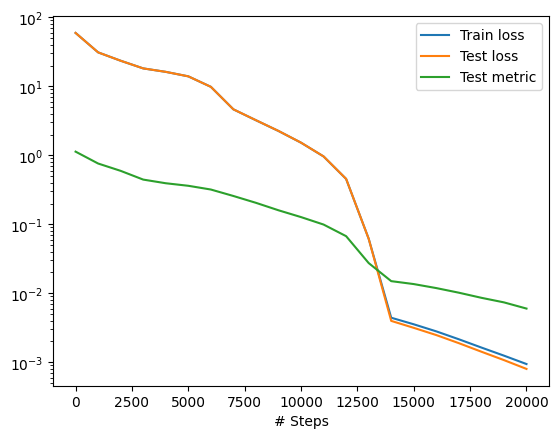

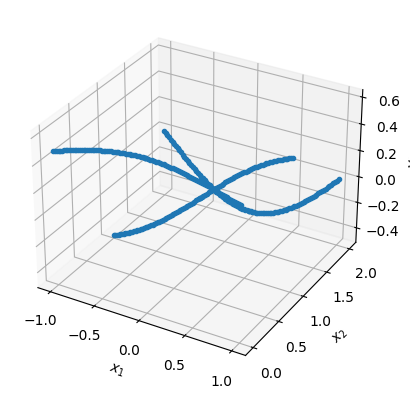

In [23]:
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

In [24]:
model.predict([[0.0, 0.0]])

array([[0.6314188]], dtype=float32)

In [25]:
def predict_for_n(points):
    prediction = model.predict(points)
    return np.array(prediction)

In [26]:
def plot_results_for_n(n, num_points=10):
    x = np.linspace(-L, L, num=num_points)
    points = np.array([[i, n] for i in x])
    predictions = predict_for_n(points)
    true_values = psi(points)
    
    fig, ax = plt.subplots()
    ax.plot(x, predictions, 'bo', label='predicted')
    ax.plot(x, true_values, '--', label='true')
    fig.legend()

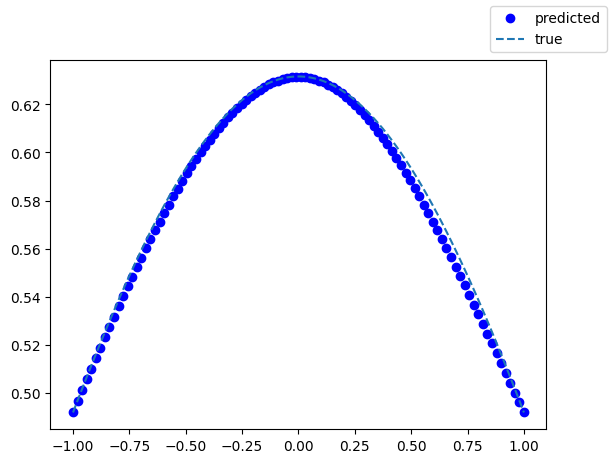

In [32]:
plot_results_for_n(0, 100)

In [ ]:
psi_0([0, 0])

In [ ]:
psi(np.array([[0, 0]]))